In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scripts.kaggle.helpers import make_submission
import datetime
from tqdm import tqdm
import gc
import itertools
from multiprocessing import Pool
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 16)

%load_ext autotime

Populating the interactive namespace from numpy and matplotlib


In [2]:
HEADER = ["fecha_dato", "ncodpers", "ind_empleado",
          "pais_residencia", "sexo", "age", "fecha_alta",
          "ind_nuevo", "antiguedad", "indrel", "ult_fec_cli_1t",
          "indrel_1mes", "tiprel_1mes", "indresi", "indext",
          "conyuemp", "canal_entrada", "indfall", "tipodom",
          "cod_prov", "nomprov", "ind_actividad_cliente",
          "renta", "segmento", "ind_ahor_fin_ult1",
          "ind_aval_fin_ult1", "ind_cco_fin_ult1",
          "ind_cder_fin_ult1", "ind_cno_fin_ult1",
          "ind_ctju_fin_ult1", "ind_ctma_fin_ult1",
          "ind_ctop_fin_ult1", "ind_ctpp_fin_ult1",
          "ind_deco_fin_ult1", "ind_deme_fin_ult1",
          "ind_dela_fin_ult1", "ind_ecue_fin_ult1",
          "ind_fond_fin_ult1", "ind_hip_fin_ult1",
          "ind_plan_fin_ult1", "ind_pres_fin_ult1",
          "ind_reca_fin_ult1", "ind_tjcr_fin_ult1",
          "ind_valo_fin_ult1", "ind_viv_fin_ult1",
          "ind_nomina_ult1", "ind_nom_pens_ult1",
          "ind_recibo_ult1"]

time: 6.93 ms


In [3]:
description, train, added_products, label_encoder, encoders = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/train_data.train_data', 'rb'))

time: 29.6 s


In [4]:
train.reset_index(inplace=True)

time: 2.29 ms


In [6]:
for prefix in ['pf1_exists_at_least_1_', 'pf2_exists_all_months_', 'pf3_doesnt_exist_at_all_', 'pf4_product_removed_in_past_', 'pf5_product_added_in_past_', 'pf6_product_removed_recently_', 'pf7_product_added_recently_']:
    subs = train.loc[:, ['current_'+h for h in HEADER[24:]]].astype(bool)
    pf1 = train.loc[:, [prefix+h for h in HEADER[24:]]].astype(bool)
    subs.columns = pf1.columns

    new_pf1 = (pf1 & (~subs)).astype(int)

    train.loc[:, [prefix+h for h in HEADER[24:]]] = new_pf1

time: 1.12 s


In [7]:
description, test1 = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/13.test_data1.test_data1', 'rb'))
test1.drop([500000], inplace=True)
description, test2 = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/13.test_data2.test_data2', 'rb'))
test = pd.concat((test1, test2))
test.set_index('ncodpers', inplace=True)
del test1, test2
gc.collect()
test.reset_index(inplace=True)

time: 1min 4s


---
# 17. product features positive if the the product doesnt exist, no user lag feature, nor raw attrs, no raw subs
---

In [8]:
for prefix in ['pf1_exists_at_least_1_', 'pf2_exists_all_months_', 'pf3_doesnt_exist_at_all_', 'pf4_product_removed_in_past_', 'pf5_product_added_in_past_', 'pf6_product_removed_recently_', 'pf7_product_added_recently_']:
    subs = test.loc[:, ['current_'+h for h in HEADER[24:]]].astype(bool)
    pf1 = test.loc[:, [prefix+h for h in HEADER[24:]]].astype(bool)
    subs.columns = pf1.columns

    new_pf1 = (pf1 & (~subs)).astype(int)

    test.loc[:, [prefix+h for h in HEADER[24:]]] = new_pf1

time: 4.47 s


In [9]:
user_attributes = ['age', 'ind_nuevo', 'antiguedad', 'indrel_1mes', 'tiprel_1mes',
                   'canal_entrada', 'ind_actividad_cliente', 'segmento',
                   'pais_residencia', 'indrel', 'indresi', 'indext', 'conyuemp',
                   'indfall', 'nomprov']

for col in user_attributes:
    del train['old_1_' + col], train['old_2_' + col], train['old_3_'+ col], train['old_4_' + col]
    del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col], test['old_4_' + col]

for col in user_attributes:
    del train['uf1_changed_recently_' + col], train['uf2_changed_earlier_' + col], train['uf3_times_changed_'+ col]
    del test['uf1_changed_recently_' + col], test['uf2_changed_earlier_' + col], test['uf3_times_changed_' + col]

time: 1min 13s


In [10]:
for col in HEADER[24:]:
    del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col]
    del train['old_1_' + col], train['old_2_' + col], train['old_3_' + col]

time: 11.7 s


In [11]:
print train.shape
print test.shape

(441652, 212)
(929615, 212)
time: 1.06 ms


In [12]:
def test_train_split(df, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

time: 6.54 ms


In [13]:
# train.reset_index(inplace=True)
# test.reset_index(inplace=True)
added_products.reset_index(inplace=True)
cv, tr, rows = test_train_split(train, 0.05)


cv_y = added_products.ix[rows]
tr_y = added_products.drop(rows)

cv.set_index('ncodpers', inplace=True)
tr.set_index('ncodpers', inplace=True)

print cv.shape, cv_y.shape
print tr.shape, tr_y.shape


dtr = xgb.DMatrix(tr, label=tr_y.encoded_products)
dcv = xgb.DMatrix(cv, label=cv_y.encoded_products)



param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(dtr, 'train'), (dcv, 'cv')]

(22082, 211) (22082, 3)
(419570, 211) (419570, 3)
time: 3.19 s


In [47]:
xgb_model = xgb.train(plist, dtr, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.759268	cv-MAP@7:0.759306
[1]	train-MAP@7:0.76224	cv-MAP@7:0.761888
[2]	train-MAP@7:0.76214	cv-MAP@7:0.761571
[3]	train-MAP@7:0.762821	cv-MAP@7:0.762069
[4]	train-MAP@7:0.763353	cv-MAP@7:0.762159
[5]	train-MAP@7:0.764511	cv-MAP@7:0.763835
[6]	train-MAP@7:0.764614	cv-MAP@7:0.76379
[7]	train-MAP@7:0.766852	cv-MAP@7:0.765692
[8]	train-MAP@7:0.767302	cv-MAP@7:0.765827
[9]	train-MAP@7:0.767529	cv-MAP@7:0.766235
[10]	train-MAP@7:0.767786	cv-MAP@7:0.766461
[11]	train-MAP@7:0.768063	cv-MAP@7:0.766597
[12]	train-MAP@7:0.768263	cv-MAP@7:0.766733
[13]	train-MAP@7:0.768494	cv-MAP@7:0.76696
[14]	train-MAP@7:0.768806	cv-MAP@7:0.767277
[15]	train-MAP@7:0.769207	cv-MAP@7:0.767458
[16]	train-MAP@7:0.769347	cv-MAP@7:0.767412
[17]	train-MAP@7:0.769412	cv-MAP@7:0.767639
[18]	train-MAP@7:0.769514	cv-MAP@7:0.767684
[19]	train-MAP@7:0.769602	cv-MAP@7:0.76782
[20]	train-MAP@7:0.769733	cv-MAP@7:0.767639
[21]	train-MAP@7:0.769922	cv-MAP@7:0.767865
[22]	train-MAP@7:0.770165	cv-MAP@7:0.768092
[23

KeyboardInterrupt: 

time: 32min


In [ ]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [ ]:
def get_n_iter_from_evals_results(p2):
    max_df = p2.loc[p2.map7_cv == p2.map7_cv.max(), :]
    print max_df
    n = max_df.index.max()
    return n

optimal_index = get_n_iter_from_evals_results(p2)
optimal_n = int(optimal_index/0.95)
print "@@@@@@@@ Results @@@@@@@@"
print optimal_n, 'optimal_n', optimal_index

In [14]:
optimal_n = 130

time: 812 µs


In [15]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)
test.set_index('ncodpers', inplace=True)


dtrain = xgb.DMatrix(train, label=added_products.encoded_products)

time: 3.23 s


In [16]:
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.753943	cv-MAP@7:0.749479
[1]	train-MAP@7:0.762855	cv-MAP@7:0.758084
[2]	train-MAP@7:0.762926	cv-MAP@7:0.75908
[3]	train-MAP@7:0.763846	cv-MAP@7:0.758989
[4]	train-MAP@7:0.766265	cv-MAP@7:0.761706
[5]	train-MAP@7:0.766475	cv-MAP@7:0.761435
[6]	train-MAP@7:0.767007	cv-MAP@7:0.762205
[7]	train-MAP@7:0.767259	cv-MAP@7:0.763065
[8]	train-MAP@7:0.767362	cv-MAP@7:0.762567
[9]	train-MAP@7:0.767657	cv-MAP@7:0.76311
[10]	train-MAP@7:0.76797	cv-MAP@7:0.762839
[11]	train-MAP@7:0.767996	cv-MAP@7:0.762839
[12]	train-MAP@7:0.768063	cv-MAP@7:0.762884
[13]	train-MAP@7:0.76821	cv-MAP@7:0.763337
[14]	train-MAP@7:0.76862	cv-MAP@7:0.763608
[15]	train-MAP@7:0.768704	cv-MAP@7:0.764016
[16]	train-MAP@7:0.769037	cv-MAP@7:0.764288
[17]	train-MAP@7:0.769328	cv-MAP@7:0.764876
[18]	train-MAP@7:0.769395	cv-MAP@7:0.765148
[19]	train-MAP@7:0.769521	cv-MAP@7:0.765239
[20]	train-MAP@7:0.769647	cv-MAP@7:0.765193
[21]	train-MAP@7:0.769807	cv-MAP@7:0.765284
[22]	train-MAP@7:0.769852	cv-MAP@7:0.765284
[23

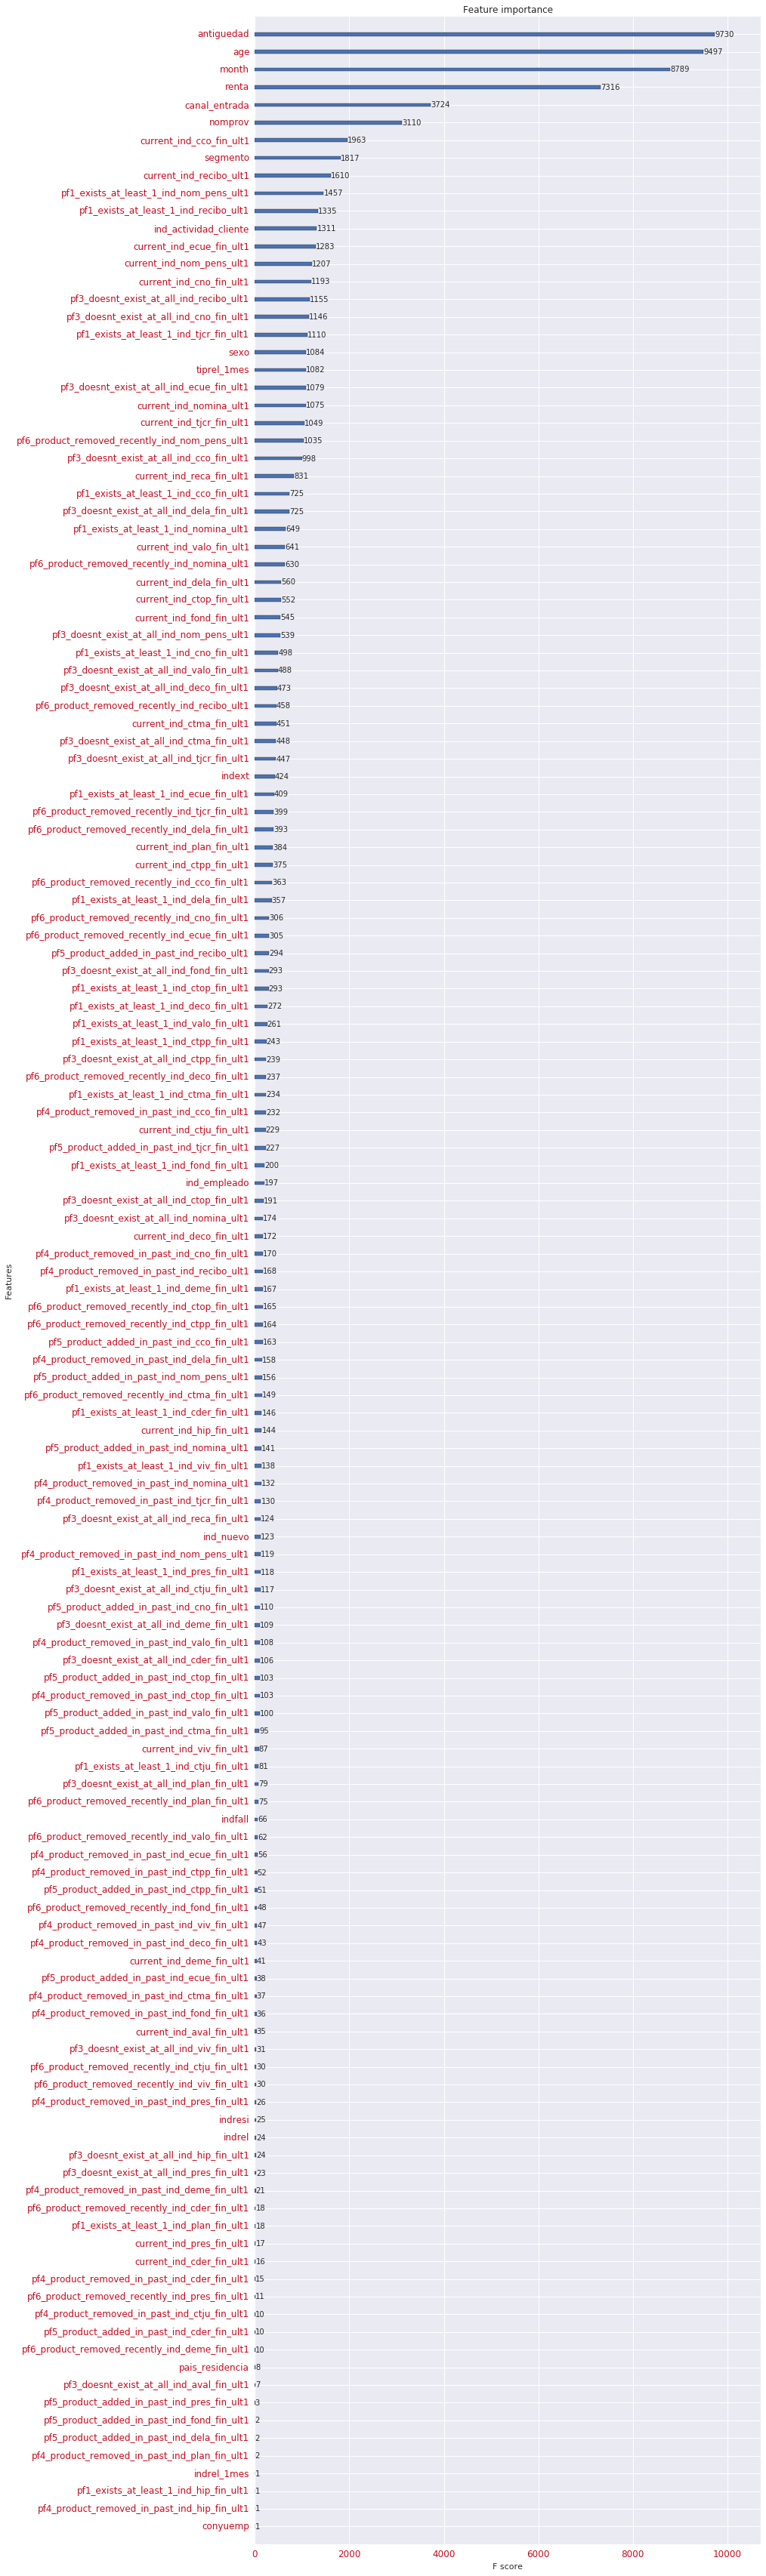

time: 3.54 s


In [17]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

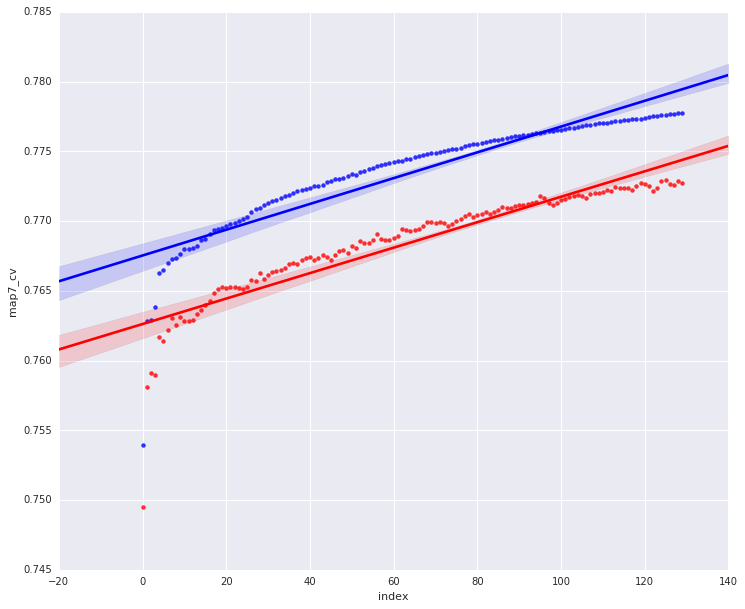

time: 1.07 s


In [18]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [19]:
main_xgb_model.save_model('data/17.xgboost_model_save.xgb')
make_submission('data/17.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/17.xgboost_model_save.xgb.zip
uploading to s3 done
time: 727 ms


In [20]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)

time: 30.1 s


In [21]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [11:27<00:00, 1351.57it/s]

time: 11min 31s


In [22]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/17.xgb_trained_on_all_months_jacobian_change_subs.csv'
description = '17. subs features that are true for unsubscribed products,\
                no user attrs, no user lags, no subs lags' +\
                str(param) + " iterations " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/17.xgb_trained_on_all_months_jacobian_change_subs.csv.zip
uploading to s3 done
Uploading submission data/17.xgb_trained_on_all_months_jacobian_change_subs.csv.zip
Upload done
time: 54.4 s


In [23]:
pickle_description = '17 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/17.xgb_trained_on_all_months_jacobian_change_subs.csv.pickle.zip
uploading to s3 done
time: 2min 17s


----
# 17.1 Jacobian similarities with above product sub related features
----

In [25]:
del test['xgb_preds'], test['added_products']

jacob_train = pickle.load(open('data/15.Jacobian_similarity_features.train_data', 'rb'))
jacob_test = pickle.load(open('data/15.Jacobian_similarity_features.test_data', 'rb'))

for col in ['jacob_'+h for h in HEADER[24:]]:
    test[col] = jacob_test[col]
    train[col] = jacob_train[col]

time: 16.8 s


In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
added_products.head()

In [27]:
print train.shape
print test.shape
print added_products.shape

(441652, 235)
(929615, 235)
(441652, 2)
time: 1.46 ms


In [28]:
train.reset_index(inplace=True)
# test.reset_index(inplace=True)
added_products.reset_index(inplace=True)
cv, tr, rows = test_train_split(train, 0.05)


cv_y = added_products.ix[rows]
tr_y = added_products.drop(rows)

cv.set_index('ncodpers', inplace=True)
tr.set_index('ncodpers', inplace=True)

print cv.shape, cv_y.shape
print tr.shape, tr_y.shape


dtr = xgb.DMatrix(tr, label=tr_y.encoded_products)
dcv = xgb.DMatrix(cv, label=cv_y.encoded_products)



param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(dtr, 'train'), (dcv, 'cv')]

(22082, 235) (22082, 3)
(419570, 235) (419570, 3)
time: 4.05 s


In [29]:
xgb_model = xgb.train(plist, dtr, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.75978	cv-MAP@7:0.760212
[1]	train-MAP@7:0.765298	cv-MAP@7:0.766824
[2]	train-MAP@7:0.766401	cv-MAP@7:0.768001
[3]	train-MAP@7:0.766821	cv-MAP@7:0.768409
[4]	train-MAP@7:0.76821	cv-MAP@7:0.76868
[5]	train-MAP@7:0.768353	cv-MAP@7:0.768726
[6]	train-MAP@7:0.768453	cv-MAP@7:0.768726
[7]	train-MAP@7:0.769073	cv-MAP@7:0.769224
[8]	train-MAP@7:0.769404	cv-MAP@7:0.76936
[9]	train-MAP@7:0.769552	cv-MAP@7:0.768635
[10]	train-MAP@7:0.769617	cv-MAP@7:0.768635
[11]	train-MAP@7:0.769988	cv-MAP@7:0.768726
[12]	train-MAP@7:0.7702	cv-MAP@7:0.769088
[13]	train-MAP@7:0.770355	cv-MAP@7:0.76936
[14]	train-MAP@7:0.770494	cv-MAP@7:0.768862
[15]	train-MAP@7:0.770856	cv-MAP@7:0.769133
[16]	train-MAP@7:0.77107	cv-MAP@7:0.769405
[17]	train-MAP@7:0.771225	cv-MAP@7:0.769541
[18]	train-MAP@7:0.771323	cv-MAP@7:0.76936
[19]	train-MAP@7:0.77144	cv-MAP@7:0.769496
[20]	train-MAP@7:0.771642	cv-MAP@7:0.769586
[21]	train-MAP@7:0.771745	cv-MAP@7:0.769586
[22]	train-MAP@7:0.77184	cv-MAP@7:0.769677
[23]	trai

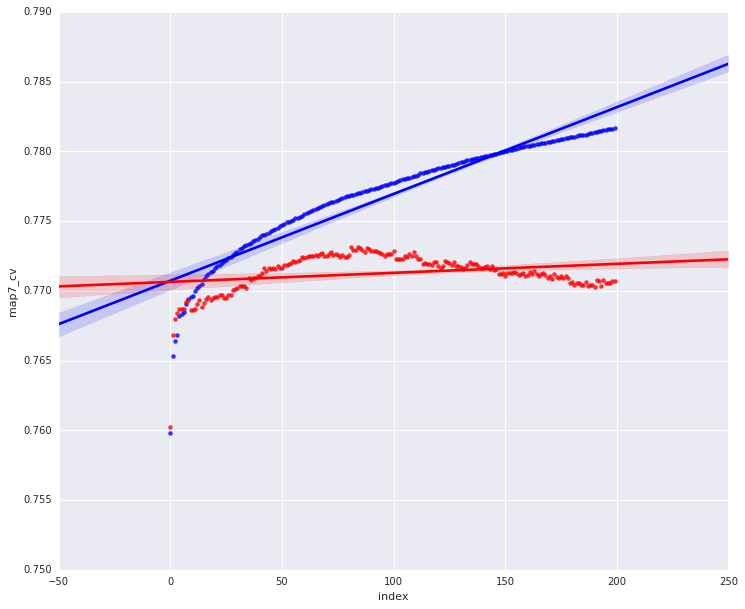

time: 428 ms


In [30]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [31]:
def get_n_iter_from_evals_results(p2):
    max_df = p2.loc[p2.map7_cv == p2.map7_cv.max(), :]
    print max_df
    n = max_df.index.max()
    return n

optimal_index = get_n_iter_from_evals_results(p2)
optimal_n = int(optimal_index/0.95)
print "@@@@@@@@ Results @@@@@@@@"
print optimal_n, 'optimal_n', optimal_index

    index  map7_train   map7_cv
84     84    0.776991  0.773164
@@@@@@@@ Results @@@@@@@@
88 optimal_n 84
time: 7.09 ms


In [32]:
optimal_n = 110

time: 841 µs


In [33]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)
# test.set_index('ncodpers', inplace=True)


dtrain = xgb.DMatrix(train, label=added_products.encoded_products)

time: 2.87 s


In [34]:
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.757149	cv-MAP@7:0.760801
[1]	train-MAP@7:0.763513	cv-MAP@7:0.766326
[2]	train-MAP@7:0.764564	cv-MAP@7:0.768046
[3]	train-MAP@7:0.767305	cv-MAP@7:0.770265
[4]	train-MAP@7:0.767669	cv-MAP@7:0.771443
[5]	train-MAP@7:0.76811	cv-MAP@7:0.771986
[6]	train-MAP@7:0.768625	cv-MAP@7:0.771624
[7]	train-MAP@7:0.768985	cv-MAP@7:0.77185
[8]	train-MAP@7:0.769149	cv-MAP@7:0.771986
[9]	train-MAP@7:0.769519	cv-MAP@7:0.771398
[10]	train-MAP@7:0.769786	cv-MAP@7:0.771805
[11]	train-MAP@7:0.769948	cv-MAP@7:0.772394
[12]	train-MAP@7:0.770153	cv-MAP@7:0.772394
[13]	train-MAP@7:0.770305	cv-MAP@7:0.772983
[14]	train-MAP@7:0.770448	cv-MAP@7:0.772666
[15]	train-MAP@7:0.770639	cv-MAP@7:0.772394
[16]	train-MAP@7:0.770782	cv-MAP@7:0.772349
[17]	train-MAP@7:0.770908	cv-MAP@7:0.772937
[18]	train-MAP@7:0.771123	cv-MAP@7:0.773209
[19]	train-MAP@7:0.771304	cv-MAP@7:0.773028
[20]	train-MAP@7:0.771418	cv-MAP@7:0.773209
[21]	train-MAP@7:0.771566	cv-MAP@7:0.7733
[22]	train-MAP@7:0.771719	cv-MAP@7:0.77339
[23

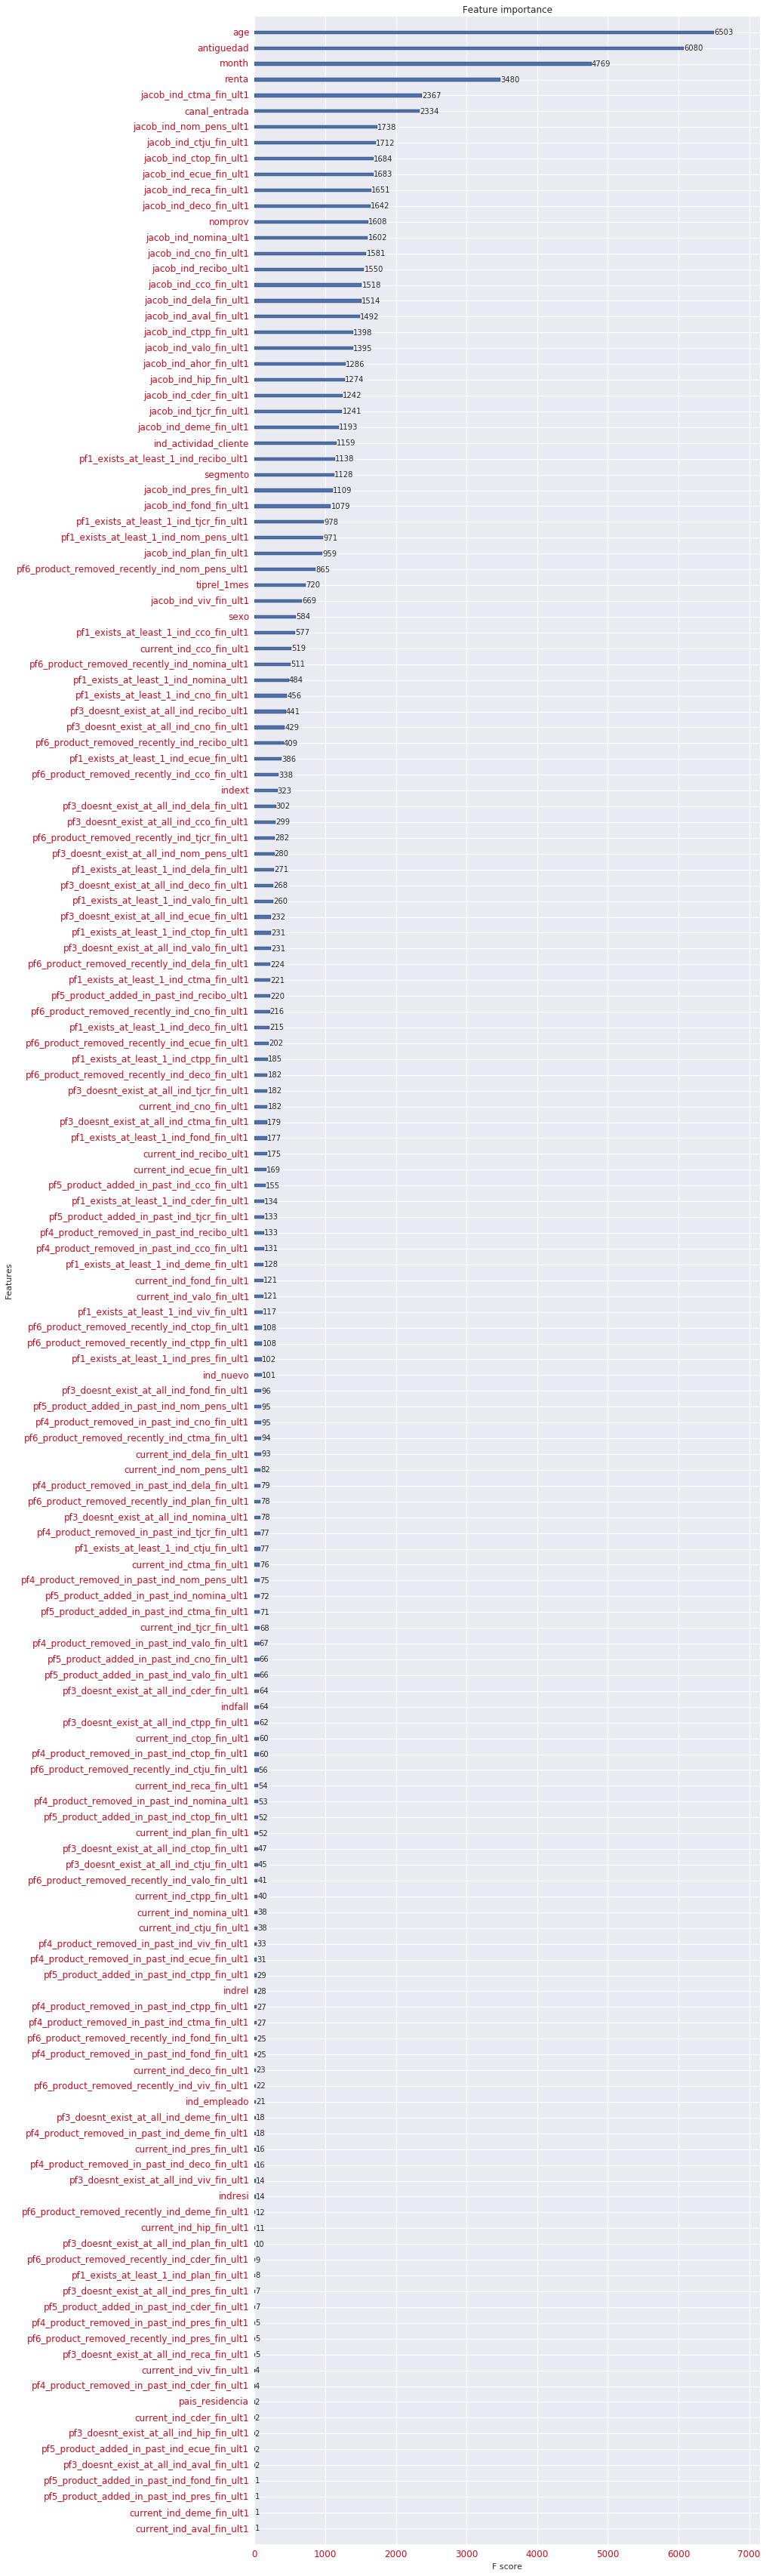

time: 3.31 s


In [35]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

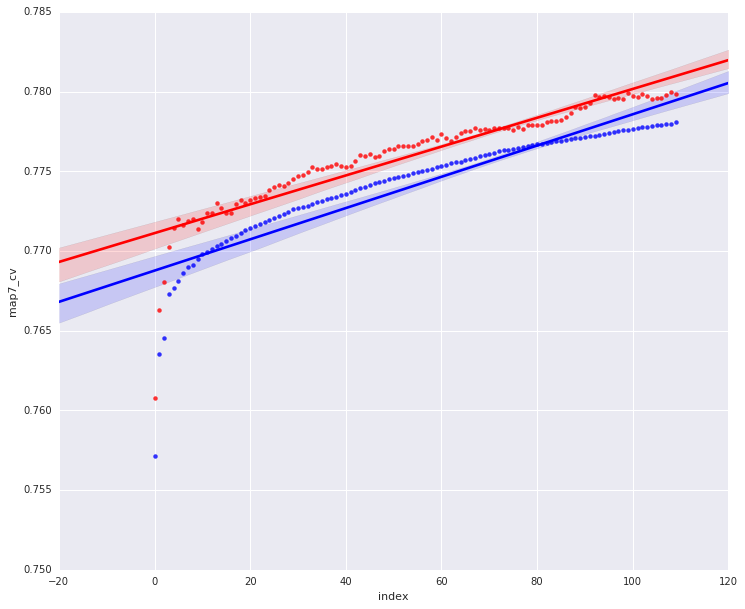

time: 382 ms


In [36]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [37]:
main_xgb_model.save_model('data/17.1.xgboost_model_save.xgb')
make_submission('data/17.1.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/17.1.xgboost_model_save.xgb.zip
uploading to s3 done
time: 623 ms


In [38]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)

time: 27.9 s


In [39]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [11:49<00:00, 1311.11it/s]

time: 11min 52s


In [40]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/17.1.xgb_trained_on_all_months_jacobian_change_subs.csv'
description = '17.1 jacobians plus subs features that are true for unsubscribed products,\
                no user attrs, no user lags, no subs lags' +\
                str(param) + " iterations " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/17.1.xgb_trained_on_all_months_jacobian_change_subs.csv.zip
uploading to s3 done
Uploading submission data/17.1.xgb_trained_on_all_months_jacobian_change_subs.csv.zip
Upload done
time: 19.9 s


In [41]:
pickle_description = '17.1 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/17.1.xgb_trained_on_all_months_jacobian_change_subs.csv.pickle.zip
uploading to s3 done
time: 1min 52s
